# Pairs Trading using Sig Trader

Context: we have a universe with $d=2$ stocks and we assume that although both assets have their own underlying dynamics, their joint behavior should hold some predictability. For the sake of simplicity, in this notebook we will assume that the spread between the two assets is mean-reverting. The more general approach to pairs trading isn't much more complicated.

In theory, a simple Order 1 Sig Trader can already capture the mean-reverting dynamic in pairs trading. Indeed, since we have no outside information $f_t$, our market factor process is simply $\hat{Z}_t=(t,X_t,Y_t)$ where $X_t$ is our first asset and $Y_t$ our second asset. Therefore the $1$-truncated signature of the stopped process $(\hat{Z}_s)_{0\leq s \leq t}$ reads:

$$\hat{\mathbb{Z}}_{0,t}^{\leq 1}=\bigg(1,
\begin{bmatrix}
t \\ X_t-X_0 \\ Y_t-Y_0
\end{bmatrix}\bigg)$$

Therefore, an Order 1 Sig Trader could easily learn to rebuild the spread $Y_t-X_t$ using signature terms given that
$\langle \ell, \mathbb{Z}_{0,t}^{\leq 1} \rangle = \ell^0 \cdot 1 + \ell^1 \cdot t + \ell^2 \cdot (X_t-X_0) + \ell^3 \cdot (Y_t-Y_0)$, and thus it could set $\xi_t^1 \propto Y_t-X_t$ and $\xi_t^2 \propto X_t-Y_t$, effectively defining a mean-reversion strategy.

Note that in order to capture the spread, i.e. in order to have $\langle \ell, \mathbb{Z}_{0,t}^{\leq 1} \rangle \propto X_t-Y_t$, we must have 
- $\ell^0\simeq 0$ because there is no needed to recenter the spread $(X_t-X_0) - (Y_t-Y_0)$ since we have $X_0=Y_0$
- $\ell^1\simeq 0$ since time doesn't matter (we model stationary processes)
- $\ell^2 \simeq - \ell^3$ since we want to capture the spread. The absolute magnitude of these two terms will determine the size of the positions we take and therefore will depend on the variance criterion $\Delta$ of the Sig Trader

### 0. Import libraries

In [1]:
import trading_strategy
import torch
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import quantstats as qs

sns.set_theme()

### 1. Define some utils

In [2]:
def generate_synthetic_pairs(batch_size: int, T: int, delta_t: float, X_0: float, Y_0: float, sigma_x: float, sigma_y: float, kappa: float) -> torch.Tensor:
    """
    Generate synthetic pairs of stock prices using the Ornstein-Uhlenbeck process. (additive model)
    :param batch_size: number of pairs to generate
    :param T: time horizon (in years)
    :param freq: frequency of price updates
    :param X_0: initial price of the first stock
    :param Y_0: initial price of the second stock
    :param sigma_x: (annual) volatility of the first stock
    :param sigma_y: (annual) volatility of the second stock
    :param kappa: mean reversion rate
    :return: a tensor of shape (batch_size, n, 2) containing the price paths of the two stocks
    """
    # we use the additive model instead of the multiplicative model (as proposed in the paper)
    n_assets = 2
    n_points = int(T/delta_t)
    price_paths = torch.zeros(batch_size, n_points, n_assets)
    price_paths[:,:,0] = X_0
    price_paths[:,:,1] = Y_0

    for i in range(1,n_points):
        # # additive model
        # price_paths[:,i,0] = price_paths[:,i-1,0] + sigma_x*torch.randn(batch_size)*np.sqrt(delta_t)
        # price_paths[:,i,1] = price_paths[:,i-1,1] + sigma_y*torch.randn(batch_size)*np.sqrt(delta_t) + kappa*(price_paths[:,i-1,0] - price_paths[:,i-1,1])*delta_t

        # multiplicative model
        price_paths[:,i,0] = price_paths[:,i-1,0] + sigma_x*torch.randn(batch_size)*np.sqrt(delta_t)*price_paths[:,i-1,0]
        price_paths[:,i,1] = price_paths[:,i-1,1] + sigma_y*torch.randn(batch_size)*np.sqrt(delta_t)*price_paths[:,i-1,1] + kappa*(price_paths[:,i-1,0] - price_paths[:,i-1,1])*delta_t

    return price_paths

### 2. Generate synthetic data

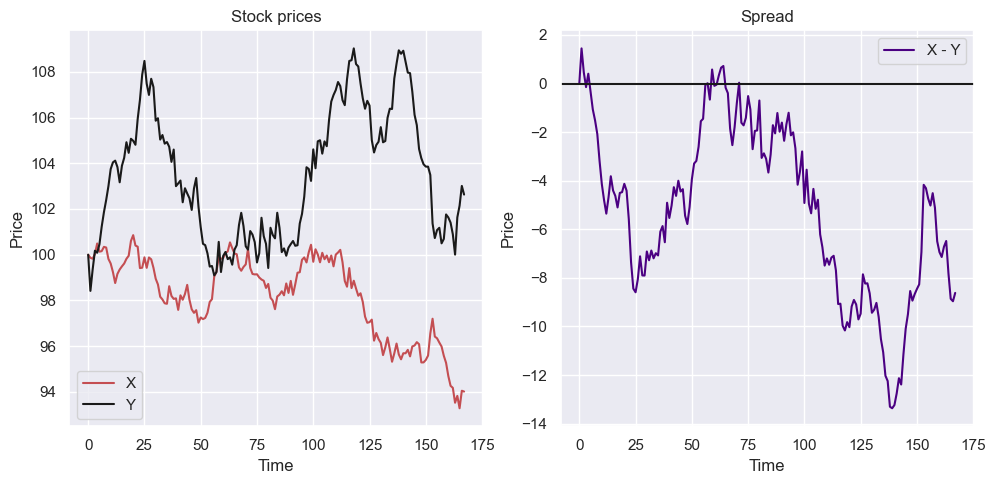

In [3]:
# Pairs Trading parameters
sigma_x = 0.2
sigma_y = 0.3
kappa = 50
freq = 252*8 # hourly data
delta_t = 1/freq # time between two points in the time series
n_years = 1/12 # 1 month of data
X_0 = 100
Y_0 = 100

batch_size = 10000 # number of pairs to generate (the more the better for the Sig Trader to learn)
price_paths = generate_synthetic_pairs(batch_size, n_years, delta_t, X_0, Y_0, sigma_x, sigma_y, kappa)
n_points = price_paths.shape[1] # number of points in each time series

info_data = torch.zeros((batch_size, n_points, 0)) # no info data

# plot the prices of an arbitrary pair in the batch
sample_index = 0
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(price_paths[sample_index,:,0], label="X", color='r')
axs[0].plot(price_paths[sample_index,:,1], label="Y" , color='k')
axs[0].set_title("Stock prices")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Price")
axs[0].legend()

axs[1].plot(price_paths[sample_index,:,0] - price_paths[sample_index,:,1], label="X - Y", color='indigo')
axs[1].axhline(y=0, color='k')
axs[1].set_title("Spread")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Price")
axs[1].legend()

plt.tight_layout()
plt.show()

### 3. Fit Order 1 Sig Trader

In [4]:
# Sig Trader parameters
depth = 1
delta = 1 # variance criterion, not very important (simply rescale the positions xi)
ts = trading_strategy.TradingStrategy(depth, delta)
ts.fit(price_paths, info_data)

# flip functionals
for i in range(ts.d):
    ts.functionals[i] = -ts.functionals[i]

ts.print_functionals()

function compute_signature took 8.21s
mu_sig successfully computed
sigma_sig successfully computed
lambda successfully computed
Fitting successful.

L_1
Level 0:
tensor([0.0220])
Level 1:
tensor([-0.0237, -0.0737,  0.0786])
L_2
Level 0:
tensor([0.0890])
Level 1:
tensor([-0.0717,  0.0815, -0.0988])


### 4. Trade on in-sample data

In [16]:
n_traded_pairs = 10 # we trade 20 pairs (uncorrelated) from the batch
all_hourly_pnl = torch.zeros(n_traded_pairs, n_points) # hourly pnl for each pair
min_steps = 5 # minimum number of steps before trading

for i in range(n_traded_pairs):
    # trading on the i-th pair in the batch
    X = price_paths[i,:,:]
    f = info_data[i,:,:]
    xi = ts.trade(X, f, min_steps=min_steps)
    hourly_pnl_each_asset = ts.compute_pnl(X, xi) # daily pnl on this pair
    hourly_pnl_pair = torch.sum(hourly_pnl_each_asset, dim=1) # daily pnl of the pair (sum of pnl for each asset)
    all_hourly_pnl[i,1:] = hourly_pnl_pair

portfolio_hourly_pnl = torch.sum(all_hourly_pnl, dim=0) # daily pnl of the portfolio (sum of pnl for each pairs)
portfolio_cum_pnl = torch.cumsum(portfolio_hourly_pnl, dim=0) # cumulative pnl of the portfolio

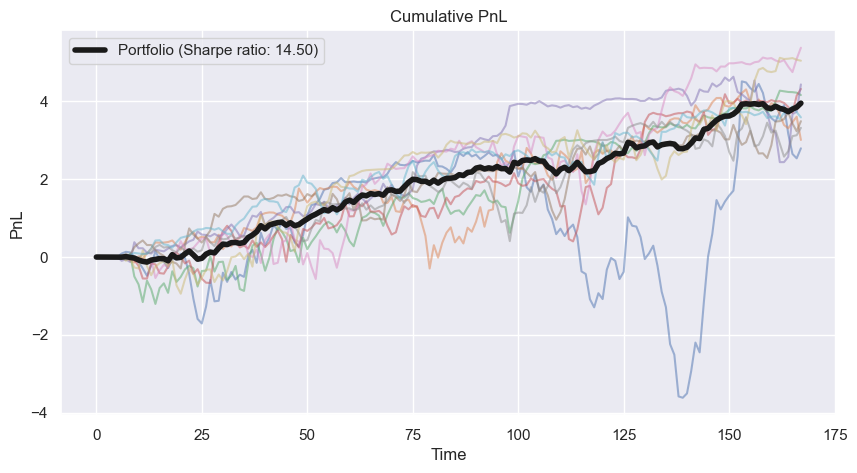

In [39]:
# plot the cumulative pnl of the portfolio
plt.figure(figsize=(10,5))
# plot the cumulative pnl of each pair we trade
for i in range(n_traded_pairs):
    plt.plot(torch.cumsum(all_hourly_pnl[i,:], dim=0), alpha=0.5)

# plot the cumulative pnl of the portfolio
rescaled_portfolio_cum_pnl = portfolio_cum_pnl/n_traded_pairs

portfolio_mean_return = torch.mean(portfolio_hourly_pnl)
portfolio_std_return = torch.std(portfolio_hourly_pnl)
portfolio_sharpe_ratio = portfolio_mean_return/portfolio_std_return * np.sqrt(freq)

plt.plot(rescaled_portfolio_cum_pnl, lw=4, color='k', label=f'Portfolio (Sharpe ratio: {portfolio_sharpe_ratio:.2f})')
plt.legend()

plt.title("Cumulative PnL")
plt.xlabel("Time")
plt.ylabel("PnL")
plt.show()

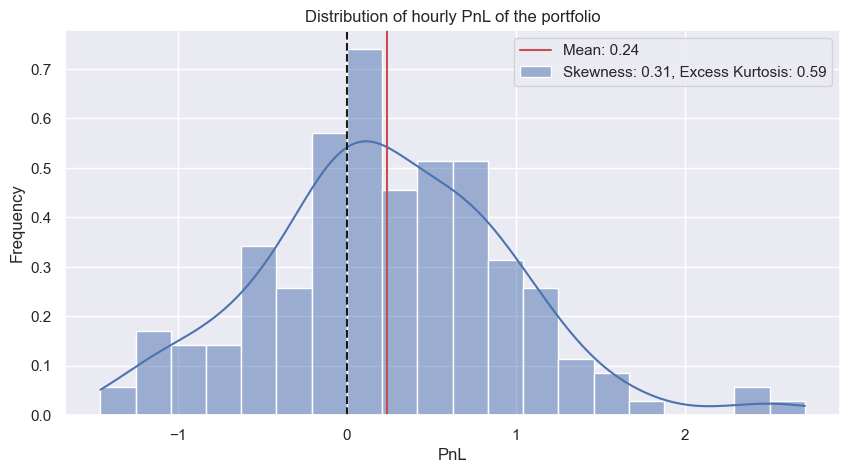

In [7]:
mean_hourly_pnl = torch.mean(portfolio_hourly_pnl)
std_hourly_pnl = torch.std(portfolio_hourly_pnl)
skew_hourly_pnl = torch.mean((portfolio_hourly_pnl - mean_hourly_pnl)**3)/std_hourly_pnl**3
kurt_hourly_pnl = torch.mean((portfolio_hourly_pnl - mean_hourly_pnl)**4)/std_hourly_pnl**4 - 3

# dist of hourly pnl of the portfolio
plt.figure(figsize=(10,5))
sns.histplot(portfolio_hourly_pnl, kde=True, bins=20, stat='density', label=f'Skewness: {skew_hourly_pnl:.2f}, Excess Kurtosis: {kurt_hourly_pnl:.2f}')
plt.axvline(x=0, color='k', ls='--')
plt.axvline(x=mean_hourly_pnl, color='r', label=f'Mean: {mean_hourly_pnl:.2f}')
plt.title("Distribution of hourly PnL of the portfolio")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### 5. Trade on out-of-sample data

In [8]:
n_traded_pairs = 10 # we trade 20 pairs (uncorrelated) from the batch
oos_all_hourly_pnl = torch.zeros(n_traded_pairs, n_points) # hourly pnl for each pair

# new, out-of-sample data
oos_price_paths = generate_synthetic_pairs(n_traded_pairs, n_years, delta_t, X_0, Y_0, sigma_x, sigma_y, kappa)
oos_info_data = torch.zeros((n_traded_pairs, n_points, 0)) # no info data

for i in range(n_traded_pairs):
    # trading on the i-th pair in the batch
    X = oos_price_paths[i,:,:]
    f = oos_info_data[i,:,:]
    xi = ts.trade(X, f)
    hourly_pnl_each_asset = ts.compute_pnl(X, xi) # daily pnl on this pair
    hourly_pnl_pair = torch.sum(hourly_pnl_each_asset, dim=1) # daily pnl of the pair (sum of pnl for each asset)
    oos_all_hourly_pnl[i,1:] = hourly_pnl_pair

oos_portfolio_hourly_pnl = torch.sum(oos_all_hourly_pnl, dim=0) # daily pnl of the portfolio (sum of pnl for each pairs)
oos_portfolio_cum_pnl = torch.cumsum(oos_portfolio_hourly_pnl, dim=0) # cumulative pnl of the portfolio

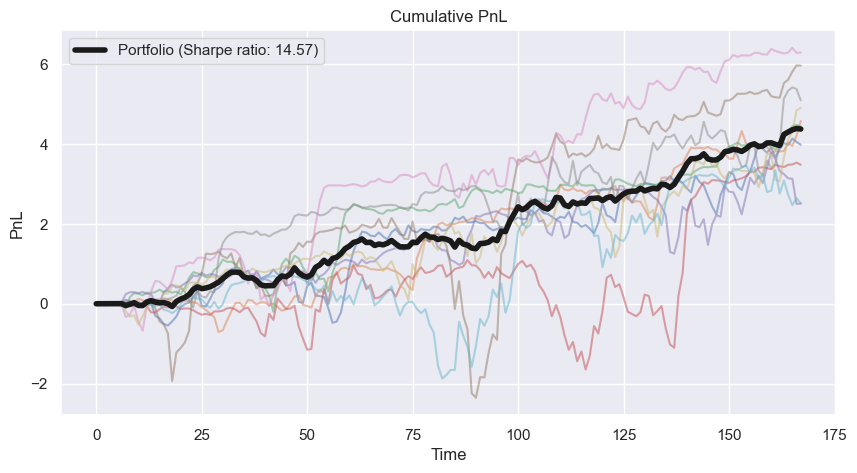

In [9]:
# plot the cumulative pnl of the portfolio
plt.figure(figsize=(10,5))
# plot the cumulative pnl of each pair we trade
for i in range(n_traded_pairs):
    plt.plot(torch.cumsum(oos_all_hourly_pnl[i,:], dim=0), alpha=0.5)

# plot the cumulative pnl of the portfolio
rescaled_oos_portfolio_cum_pnl = oos_portfolio_cum_pnl/n_traded_pairs

oos_portfolio_mean_return = torch.mean(oos_portfolio_hourly_pnl)
oos_portfolio_std_return = torch.std(oos_portfolio_hourly_pnl)
oos_portfolio_sharpe_ratio = oos_portfolio_mean_return/oos_portfolio_std_return * np.sqrt(freq)

plt.plot(rescaled_oos_portfolio_cum_pnl, lw=4, color='k', label=f'Portfolio (Sharpe ratio: {oos_portfolio_sharpe_ratio:.2f})')
plt.legend()

plt.title("Cumulative PnL")
plt.xlabel("Time")
plt.ylabel("PnL")
plt.show()

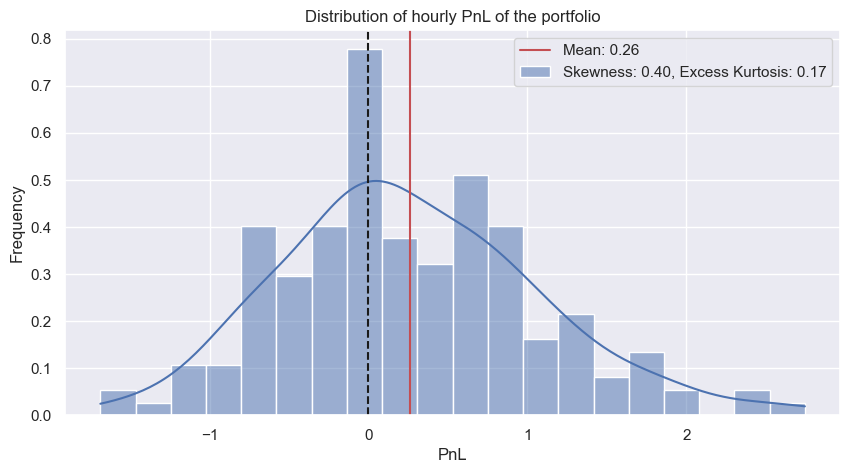

In [10]:
oos_mean_hourly_pnl = torch.mean(oos_portfolio_hourly_pnl)
oos_std_hourly_pnl = torch.std(oos_portfolio_hourly_pnl)
oos_skew_hourly_pnl = torch.mean((oos_portfolio_hourly_pnl - oos_mean_hourly_pnl)**3)/oos_std_hourly_pnl**3
oos_kurt_hourly_pnl = torch.mean((oos_portfolio_hourly_pnl - oos_mean_hourly_pnl)**4)/oos_std_hourly_pnl**4 - 3

# dist of hourly pnl of the portfolio
plt.figure(figsize=(10,5))
sns.histplot(oos_portfolio_hourly_pnl, kde=True, bins=20, stat='density', label=f'Skewness: {oos_skew_hourly_pnl:.2f}, Excess Kurtosis: {oos_kurt_hourly_pnl:.2f}')
plt.axvline(x=0, color='k', ls='--')
plt.axvline(x=oos_mean_hourly_pnl, color='r', label=f'Mean: {oos_mean_hourly_pnl:.2f}')
plt.title("Distribution of hourly PnL of the portfolio")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.legend()
plt.show()

We see that performance is the same between in-sample and out-of-sample data. This means that the Sig Trader is able to generalize and does not overfit. In other words, the Sig Trader truly understands how to capture pairs trading signals.